In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from shapely.ops import nearest_points 

In [5]:
# Configure Overpass API settings
ox.settings.max_query_area_size = 100000000

In [3]:
slum_shapefile_path = "/Users/aneeshmugulur/Documents/Capstone/Blr_slum_points/blr_slums.shp"
slum_locations = gpd.read_file(slum_shapefile_path)

In [4]:
slum_locations.head()

Slum_ID       Slum_Name       SlumLoclty   No_HH Pucca_Hse SemiPccaHs  \
0     312   Doddanekkundi    Doddanekkundi  5000.0      1000       3972   
1     110  Padarayan Pura  PADARAYANA PURA  5000.0      1000       4000   
2     306           Hoodi            Hoodi  5000.0       100       4700   
3     290    Kaveri Nagar        K R Puram  4000.0       300       3600   
4       1   Rajendranagar      KORAMANGALA  3600.0       275       2680   

  Kaccha_Hse Elec_Poles Comn_Taps Pub_Toilet Sewer Manholes      Source  \
0         28        Yes       Yes         No   Yes      Yes  NSDF, 2015   
1          0        Yes       Yes        Yes   Yes       No  NSDF, 2015   
2        200        Yes       Yes         No   Yes       No  NSDF, 2015   
3        100        Yes       Yes        Yes   Yes      Yes  NSDF, 2015   
4        645        Yes       Yes        Yes   Yes      Yes  NSDF, 2015   

    Bndry_Ref     Area  DensityHPH      PbyA  ORIG_FID  \
0  NSDF, 2015  59.6765       83.79  0.007227         0   
1  NSDF, 2015   7.7464      645.46  0.017017         1   
2  NSDF, 2015   0.9309     5371.15  0.052670         2   
3  NSDF, 2015   8.6663      461.56  0.026140         3   
4  NSDF, 2015   9.6814      371.85  0.013826         4   

                    geometry  
0  POINT (77.69458 12.97080)  
1  POINT (77.55293 12.96526)  
2  POINT (77.71853 12.99671)  
3  POINT (77.70591 12.99728)  
4  POINT (77.61737 12.94664)

In [5]:
slum_locations.shape

(312, 19)

In [6]:
bus_stop_shapefile_path = "/Users/aneeshmugulur/Documents/Capstone/busstops/bmtc_bustops_2.shp"
bus_stops = gpd.read_file(bus_stop_shapefile_path)

In [134]:
bus_stops.head()

Stop_Name   Latitude  Longitude  Num_trips_  \
0                 Baleveeranahalli  13.018604  77.393940           9   
1      Dasegowdrapalya Nelamangala  13.023470  77.394257           9   
2  Gayathrinagara Cross Sondekoppa  13.014778  77.383466         124   
3           Mallasandra Sondekoppa  13.002551  77.394141         124   
4       Nagasandrapalya Sondekoppa  13.001480  77.377390           0   

   Boothcode                                         Routes_wit  \
0   29150340                      {'D35G-BVRH': 1, '242-LA': 8}   
1   29150340                      {'D35G-BVRH': 1, '242-LA': 8}   
2   29150340  {'D35G-BVRH': 1, '374-MA': 18, '221-L': 9, '24...   
3   29150340  {'D35G-BVRH': 1, '374-MA': 18, '221-L': 9, '24...   
4   29150340                                                 {}   

                    geometry  
0  POINT (77.39394 13.01860)  
1  POINT (77.39426 13.02347)  
2  POINT (77.38347 13.01478)  
3  POINT (77.39414 13.00255)  
4  POINT (77.37739 13.00148)

In [135]:
place_name = "Bangalore, India"
G = ox.graph_from_place(place_name, network_type='walk')

In [53]:
def nearest_node(G, point):
    """
    Find the nearest node in the graph G for the given point.
    """
    nearest = ox.distance.nearest_nodes(G, point.y, point.x)
    return nearest

In [65]:
slum_distances = {}


for idx, slum in slum_locations.iterrows():
    slum_point = Point(slum['geometry'].x, slum['geometry'].y)
    nearest_node = ox.distance.nearest_nodes(G, slum_point.x, slum_point.y)
    nearest_node_coords = (G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x'])
    distance_meters = ox.distance.great_circle(slum_point.y, slum_point.x,nearest_node_coords[0], nearest_node_coords[1])
    slum_distances[idx] = {
        'nearest_bus_stop': nearest_node,
        'walking_distance_meters': distance_meters
    }

In [46]:
slum_distances_df = pd.DataFrame.from_dict(slum_distances, orient='index')

In [15]:
print(slum_distances_df)

     nearest_bus_stop  walking_distance_meters
0         10089237185                29.320925
1         10026571096                17.336458
2          7451456018                18.241233
3          1177168161                 6.902938
4          2228225854                 2.541109
..                ...                      ...
307       10839262576                35.228634
308        1438379098                11.953561
309         494244931                19.184115
310        7453259821                14.477076
311       11328801510                17.298387

[312 rows x 2 columns]


In [16]:
slum_distances_df = gpd.GeoDataFrame.from_dict(slum_distances, orient='index')
slum_distances_df.columns = ['nearest_bus_stop', 'walking_distance_meters']

<AxesSubplot:>

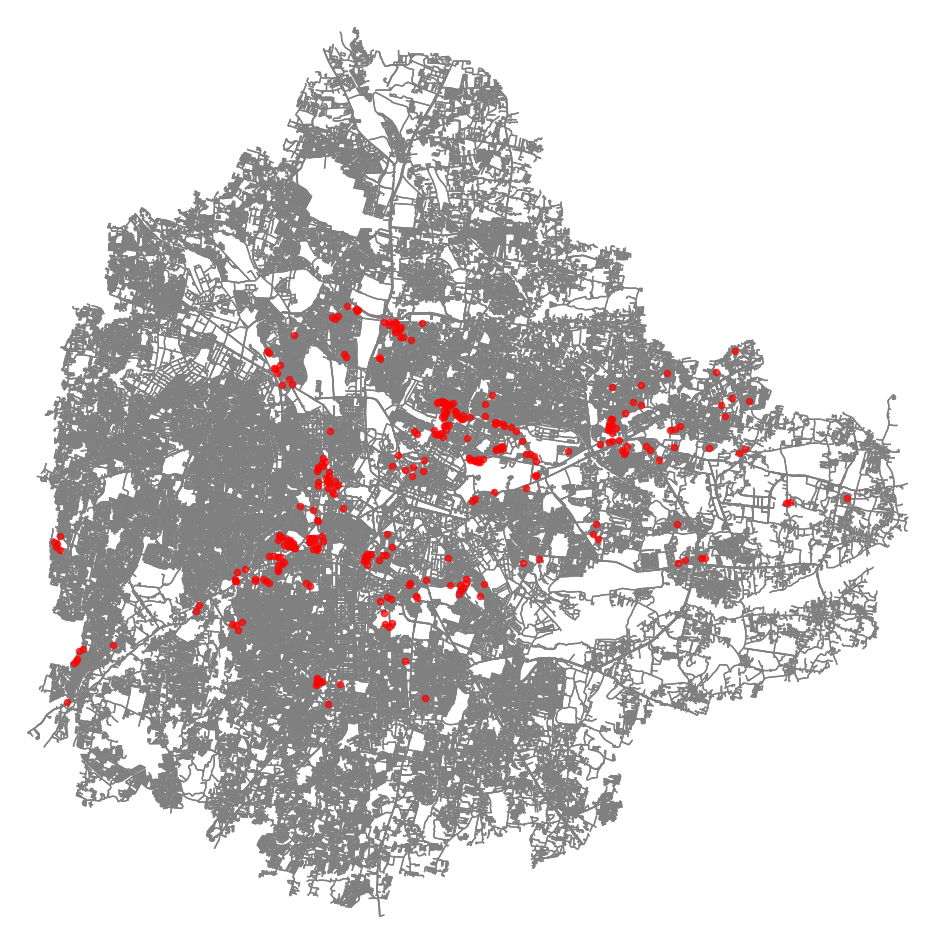

In [38]:
#check with max - ideas to improve this? k density here
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, node_color="w", edge_color="gray", bgcolor="black", node_size=0, show=False)
slum_locations.plot(ax=ax, color="red", markersize=20, alpha=0.7, label="Slum Locations")

In [22]:

average_walking_distance = slum_distances_df['walking_distance_meters'].mean()
print(f"Average Walking Distance to a Bus Stop in Bangalore: {average_walking_distance:.2f} meters")

Average Walking Distance to a Bus Stop in Bangalore: 26.89 meters


In [23]:

top_5_largest_distances = slum_distances_df.nlargest(5, 'walking_distance_meters')
print("\nTop 5 Slum Locations with Largest Walking Distances:")
print(top_5_largest_distances)


Top 5 Slum Locations with Largest Walking Distances:
     nearest_bus_stop  walking_distance_meters
5         10055294891               106.380253
238        4883420904                96.281330
112         465232549                87.392913
16         1523171104                77.566623
236        7435294199                77.104107


In [24]:

bottom_5_lowest_distances = slum_distances_df.nsmallest(5, 'walking_distance_meters')
print("\nBottom 5 Slum Locations with Lowest Walking Distances:")
print(bottom_5_lowest_distances)


Bottom 5 Slum Locations with Lowest Walking Distances:
    nearest_bus_stop  walking_distance_meters
68        1276378413                 1.694768
94        7435238233                 1.897111
52        1572383208                 2.107381
4         2228225854                 2.541109
11       11158748154                 2.878839


In [47]:
slum_distances_df = slum_distances_df.merge(slum_locations[['Slum_Name']], left_index=True, right_index=True)

In [48]:
slum_distances_df = slum_distances_df.merge(bus_stops[['Stop_Name']], left_on='nearest_bus_stop', right_index=True)

In [49]:
top_5_slums_longest_distances = slum_distances_df.nlargest(5, 'walking_distance_meters')

In [50]:
print("\nTop 5 Slum Locations with Longest Distances to Bus Stops:")
print(top_5_slums_longest_distances[['Slum_Name', 'Stop_Name', 'walking_distance_meters']])


Top 5 Slum Locations with Longest Distances to Bus Stops:
Empty DataFrame
Columns: [Slum_Name, Stop_Name, walking_distance_meters]
Index: []


## CLUSTERING

In [7]:
slum_locations.shape

(312, 19)

In [8]:
# Read CSV files
csv1 = pd.read_csv('output_1_closestfacility_analysis_busstops.csv')
csv2 = pd.read_csv('output_3_closestfacility_metrostations.csv')

# Convert 'Slum_ID' column in CSV files to object type
csv1['Slum_ID'] = csv1['Slum_ID'].astype(str)
csv2['Slum_ID'] = csv2['Slum_ID'].astype(str)

In [9]:
csv2.head()

FacilityID  FacilityRank Slum_ID          facility  FacilityCurbApproach  \
0           8             1     312    Seetharampalya                     1   
1           8             1     311    Seetharampalya                     1   
2           8             1     310    Seetharampalya                     1   
3           9             1     309             Hoodi                     2   
4          12             1     308   Krishnarajapura                     2   

   IncidentID  StartTime  EndTime  StartTimeUTC  EndTimeUTC  \
0           1        NaN      NaN           NaN         NaN   
1         276        NaN      NaN           NaN         NaN   
2          11        NaN      NaN           NaN         NaN   
3          88        NaN      NaN           NaN         NaN   
4         184        NaN      NaN           NaN         NaN   

   MetroStation_Distance  Shape_Length  
0            5538.204149   6193.087744  
1            2956.953391   3306.497360  
2            3222.054975   3602.958914  
3            3863.507786   4319.754327  
4            3317.682095   3710.363434

In [52]:
print("Unique Slum_ID in metro stations CSV:", csv2['Slum_ID'].unique())

Unique Slum_ID in metro stations CSV: ['312' '311' '310' '309' '308' '307' '306' '305' '304' '303' '302' '301'
 '300' '299' '298' '297' '296' '295' '294' '293' '292' '291' '290' '289'
 '288' '287' '286' '285' '284' '283' '282' '281' '280' '279' '278' '277'
 '276' '275' '274' '273' '272' '271' '270' '269' '268' '267' '266' '265'
 '264' '263' '262' '261' '260' '259' '258' '256' '255' '254' '253' '252'
 '251' '250' '249' '248' '247' '246' '245' '244' '243' '242' '241' '240'
 '239' '238' '237' '236' '235' '234' '233' '232' '231' '230' '229' '228'
 '227' '226' '225' '224' '223' '222' '221' '220' '219' '218' '217' '216'
 '215' '214' '213' '212' '211' '210' '209' '208' '207' '206' '205' '204'
 '203' '202' '201' '200' '199' '198' '197' '196' '195' '194' '193' '192'
 '191' '190' '189' '188' '187' '186' '185' '184' '183' '182' '181' '180'
 '179' '178' '177' '176' '175' '174' '173' '172' '171' '170' '169' '168'
 '167' '166' '165' '164' '163' '162' '161' '160' '158' '157' '156' '155'
 '154' '153' 

In [10]:
# Merge the first CSV data with the shapefile based on Slum_ID
slum_locations = slum_locations.merge(csv1[['Slum_ID', 'BusStop_Distance']], on='Slum_ID', how='left', suffixes=('_slum', '_busstop'))

# Merge the second CSV data with the shapefile based on Slum_ID
slum_locations = slum_locations.merge(csv2[['Slum_ID', 'MetroStation_Distance']], on='Slum_ID', how='left', suffixes=('_slum', '_metro'))

# Print the first few rows to verify the changes
print(slum_locations.head())

  Slum_ID       Slum_Name       SlumLoclty   No_HH Pucca_Hse SemiPccaHs  \
0     312   Doddanekkundi    Doddanekkundi  5000.0      1000       3972   
1     110  Padarayan Pura  PADARAYANA PURA  5000.0      1000       4000   
2     306           Hoodi            Hoodi  5000.0       100       4700   
3     290    Kaveri Nagar        K R Puram  4000.0       300       3600   
4       1   Rajendranagar      KORAMANGALA  3600.0       275       2680   

  Kaccha_Hse Elec_Poles Comn_Taps Pub_Toilet  ... Manholes      Source  \
0         28        Yes       Yes         No  ...      Yes  NSDF, 2015   
1          0        Yes       Yes        Yes  ...       No  NSDF, 2015   
2        200        Yes       Yes         No  ...       No  NSDF, 2015   
3        100        Yes       Yes        Yes  ...      Yes  NSDF, 2015   
4        645        Yes       Yes        Yes  ...      Yes  NSDF, 2015   

    Bndry_Ref     Area  DensityHPH      PbyA  ORIG_FID  \
0  NSDF, 2015  59.6765       83.79  0.007227  

In [11]:
slum_locations.head()

Slum_ID       Slum_Name       SlumLoclty   No_HH Pucca_Hse SemiPccaHs  \
0     312   Doddanekkundi    Doddanekkundi  5000.0      1000       3972   
1     110  Padarayan Pura  PADARAYANA PURA  5000.0      1000       4000   
2     306           Hoodi            Hoodi  5000.0       100       4700   
3     290    Kaveri Nagar        K R Puram  4000.0       300       3600   
4       1   Rajendranagar      KORAMANGALA  3600.0       275       2680   

  Kaccha_Hse Elec_Poles Comn_Taps Pub_Toilet  ... Manholes      Source  \
0         28        Yes       Yes         No  ...      Yes  NSDF, 2015   
1          0        Yes       Yes        Yes  ...       No  NSDF, 2015   
2        200        Yes       Yes         No  ...       No  NSDF, 2015   
3        100        Yes       Yes        Yes  ...      Yes  NSDF, 2015   
4        645        Yes       Yes        Yes  ...      Yes  NSDF, 2015   

    Bndry_Ref     Area  DensityHPH      PbyA  ORIG_FID  \
0  NSDF, 2015  59.6765       83.79  0.007227         0   
1  NSDF, 2015   7.7464      645.46  0.017017         1   
2  NSDF, 2015   0.9309     5371.15  0.052670         2   
3  NSDF, 2015   8.6663      461.56  0.026140         3   
4  NSDF, 2015   9.6814      371.85  0.013826         4   

                    geometry BusStop_Distance  MetroStation_Distance  
0  POINT (77.69458 12.97080)      1215.288839            5538.204149  
1  POINT (77.55293 12.96526)       224.755556            2418.829086  
2  POINT (77.71853 12.99671)       132.343947            1352.321859  
3  POINT (77.70591 12.99728)       739.800930             604.326726  
4  POINT (77.61737 12.94664)       486.525335            4148.753146  

[5 rows x 21 columns]

In [12]:
slum_locations.columns

Index(['Slum_ID', 'Slum_Name', 'SlumLoclty', 'No_HH', 'Pucca_Hse',
       'SemiPccaHs', 'Kaccha_Hse', 'Elec_Poles', 'Comn_Taps', 'Pub_Toilet',
       'Sewer', 'Manholes', 'Source', 'Bndry_Ref', 'Area', 'DensityHPH',
       'PbyA', 'ORIG_FID', 'geometry', 'BusStop_Distance',
       'MetroStation_Distance'],
      dtype='object')

In [14]:
slum_locations.head()

Slum_ID       Slum_Name       SlumLoclty   No_HH Pucca_Hse SemiPccaHs  \
0     312   Doddanekkundi    Doddanekkundi  5000.0      1000       3972   
1     110  Padarayan Pura  PADARAYANA PURA  5000.0      1000       4000   
2     306           Hoodi            Hoodi  5000.0       100       4700   
3     290    Kaveri Nagar        K R Puram  4000.0       300       3600   
4       1   Rajendranagar      KORAMANGALA  3600.0       275       2680   

  Kaccha_Hse Elec_Poles Comn_Taps Pub_Toilet  ... Manholes      Source  \
0         28        Yes       Yes         No  ...      Yes  NSDF, 2015   
1          0        Yes       Yes        Yes  ...       No  NSDF, 2015   
2        200        Yes       Yes         No  ...       No  NSDF, 2015   
3        100        Yes       Yes        Yes  ...      Yes  NSDF, 2015   
4        645        Yes       Yes        Yes  ...      Yes  NSDF, 2015   

    Bndry_Ref     Area  DensityHPH      PbyA  ORIG_FID  \
0  NSDF, 2015  59.6765       83.79  0.007227         0   
1  NSDF, 2015   7.7464      645.46  0.017017         1   
2  NSDF, 2015   0.9309     5371.15  0.052670         2   
3  NSDF, 2015   8.6663      461.56  0.026140         3   
4  NSDF, 2015   9.6814      371.85  0.013826         4   

                    geometry BusStop_Distance  MetroStation_Distance  
0  POINT (77.69458 12.97080)      1215.288839            5538.204149  
1  POINT (77.55293 12.96526)       224.755556            2418.829086  
2  POINT (77.71853 12.99671)       132.343947            1352.321859  
3  POINT (77.70591 12.99728)       739.800930             604.326726  
4  POINT (77.61737 12.94664)       486.525335            4148.753146  

[5 rows x 21 columns]

In [15]:
# Convert relevant columns to numeric types
slum_locations[['Pucca_Hse', 'SemiPccaHs', 'Kaccha_Hse', 'No_HH']] = slum_locations[['Pucca_Hse', 'SemiPccaHs', 'Kaccha_Hse', 'No_HH']].apply(pd.to_numeric, errors='coerce')

# Calculate percentages only for rows where 'No_HH' is not nullslum_locations['Pucca_Hse_Percentage'] = (slum_locations['Pucca_Hse'] / slum_locations['No_HH']) * 100
slum_locations['Pucca_Percentage'] = (slum_locations['Pucca_Hse'] / slum_locations['No_HH']) * 100
slum_locations['SemiPucca_Percentage'] = (slum_locations['SemiPccaHs'] / slum_locations['No_HH']) * 100
slum_locations['Kaccha_Percentage'] = (slum_locations['Kaccha_Hse'] / slum_locations['No_HH']) * 100

In [16]:
slum_locations.head()

Slum_ID       Slum_Name       SlumLoclty   No_HH  Pucca_Hse  SemiPccaHs  \
0     312   Doddanekkundi    Doddanekkundi  5000.0       1000        3972   
1     110  Padarayan Pura  PADARAYANA PURA  5000.0       1000        4000   
2     306           Hoodi            Hoodi  5000.0        100        4700   
3     290    Kaveri Nagar        K R Puram  4000.0        300        3600   
4       1   Rajendranagar      KORAMANGALA  3600.0        275        2680   

   Kaccha_Hse Elec_Poles Comn_Taps Pub_Toilet  ...     Area DensityHPH  \
0          28        Yes       Yes         No  ...  59.6765      83.79   
1           0        Yes       Yes        Yes  ...   7.7464     645.46   
2         200        Yes       Yes         No  ...   0.9309    5371.15   
3         100        Yes       Yes        Yes  ...   8.6663     461.56   
4         645        Yes       Yes        Yes  ...   9.6814     371.85   

       PbyA ORIG_FID                   geometry  BusStop_Distance  \
0  0.007227        0  POINT (77.69458 12.97080)       1215.288839   
1  0.017017        1  POINT (77.55293 12.96526)        224.755556   
2  0.052670        2  POINT (77.71853 12.99671)        132.343947   
3  0.026140        3  POINT (77.70591 12.99728)        739.800930   
4  0.013826        4  POINT (77.61737 12.94664)        486.525335   

   MetroStation_Distance  Pucca_Percentage SemiPucca_Percentage  \
0            5538.204149         20.000000            79.440000   
1            2418.829086         20.000000            80.000000   
2            1352.321859          2.000000            94.000000   
3             604.326726          7.500000            90.000000   
4            4148.753146          7.638889            74.444444   

   Kaccha_Percentage  
0           0.560000  
1           0.000000  
2           4.000000  
3           2.500000  
4          17.916667  

[5 rows x 24 columns]

## Distance Calculations

In [25]:
slum_locations.columns

Index(['Slum_ID', 'Slum_Name', 'SlumLoclty', 'No_HH', 'Pucca_Hse',
       'SemiPccaHs', 'Kaccha_Hse', 'Elec_Poles', 'Comn_Taps', 'Pub_Toilet',
       'Sewer', 'Manholes', 'Source', 'Bndry_Ref', 'Area', 'DensityHPH',
       'PbyA', 'ORIG_FID', 'geometry', 'BusStop_Distance',
       'MetroStation_Distance', 'Pucca_Percentage', 'SemiPucca_Percentage',
       'Kaccha_Percentage'],
      dtype='object')

In [28]:
# 1) Calculate average walking distance to bus stops
avg_busstop_distance = slum_locations['BusStop_Distance'].mean()
print(f"Average walking distance to bus stops: {avg_busstop_distance:.2f} meters")

# 2) Calculate average walking distance to metro stations
avg_metrostation_distance = slum_locations['MetroStation_Distance'].mean()
print(f"Average walking distance to metro stations: {avg_metrostation_distance:.2f} meters")

# 3) Find top 5 slums with longest walking distance to bus stops
top_5_busstop_distances = slum_locations.nlargest(5, 'BusStop_Distance')[['Slum_Name', 'BusStop_Distance']]
print("Top 5 slums with longest walking distance to bus stops:")
print(top_5_busstop_distances)

# 4) Find top 5 slums with longest walking distance to metro stations
top_5_metrostation_distances = slum_locations.nlargest(5, 'MetroStation_Distance')[['Slum_Name', 'MetroStation_Distance']]
print("Top 5 slums with longest walking distance to metro stations:")
print(top_5_metrostation_distances)

Average walking distance to bus stops: 400.85 meters
Average walking distance to metro stations: 2948.31 meters
Top 5 slums with longest walking distance to bus stops:
         Slum_Name  BusStop_Distance
0    Doddanekkundi       1215.288839
240       R P ROAD       1117.429982
150  ANNAIAH REDDY        986.667239
101     JYOTHIPURA        983.374567
45    Sanjay Nagar        945.973387
Top 5 slums with longest walking distance to metro stations:
              Slum_Name  MetroStation_Distance
24          Malliarjuna            10869.79628
11   Ulla Muslim Colony            10723.89767
122     Ulla Sub Nagara            10621.00835
15            Ulla Uppu            10476.42332
27       Ambedkar Nagar            10288.74830


In [46]:


# Define thresholds for bus stop distances
threshold_1 = 805  # meters
threshold_2 = 1610  # meters

# Calculate percentage of slums with bus stop distance within 805 meters
slums_within_805m = slum_locations[slum_locations['BusStop_Distance'] <= threshold_1]
percentage_within_805m = (len(slums_within_805m) / len(slum_locations)) * 100

# Calculate percentage of slums with bus stop distance within 1610 meters
slums_within_1610m = slum_locations[slum_locations['BusStop_Distance'] <= threshold_2]
percentage_within_1610m = (len(slums_within_1610m) / len(slum_locations)) * 100

# Print the results
print(f"Percentage of slums with bus stop distance <= {threshold_1} meters: {percentage_within_805m:.2f}%")
print(f"Percentage of slums with bus stop distance <= {threshold_2} meters: {percentage_within_1610m:.2f}%")


Percentage of slums with bus stop distance <= 805 meters: 94.55%
Percentage of slums with bus stop distance <= 1610 meters: 97.76%


In [41]:
import pandas as pd

# Select top 5 slums with longest walking distances to bus stops
top_5_busstop_distances = slum_locations.nlargest(5, 'BusStop_Distance')[
    ['Slum_Name', 'BusStop_Distance', 'No_HH', 'Pucca_Percentage', 'SemiPucca_Percentage', 'Kaccha_Percentage', 'Elec_Poles', 'Comn_Taps', 'Pub_Toilet']
]

# Display top 5 slums with longest walking distances to bus stops in table format
print("\nTop 5 slums with longest walking distance to bus stops:")
print(top_5_busstop_distances.to_string(index=False))

# Select top 5 slums with longest walking distances to metro stations
top_5_metrostation_distances = slum_locations.nlargest(5, 'MetroStation_Distance')[
    ['Slum_Name', 'MetroStation_Distance', 'No_HH', 'Pucca_Percentage', 'SemiPucca_Percentage', 'Kaccha_Percentage', 'Elec_Poles', 'Comn_Taps', 'Pub_Toilet']
]

# Display top 5 slums with longest walking distances to metro stations in table format
print("\nTop 5 slums with longest walking distance to metro stations:")
print(top_5_metrostation_distances.to_string(index=False))


Top 5 slums with longest walking distance to bus stops:
    Slum_Name  BusStop_Distance  No_HH  Pucca_Percentage  SemiPucca_Percentage  Kaccha_Percentage Elec_Poles Comn_Taps Pub_Toilet
Doddanekkundi       1215.288839 5000.0         20.000000             79.440000           0.560000        Yes       Yes         No
     R P ROAD       1117.429982   90.0         44.444444             44.444444          11.111111        Yes       Yes         No
ANNAIAH REDDY        986.667239  250.0          6.000000             82.000000          12.000000        Yes       Yes         No
   JYOTHIPURA        983.374567  360.0          6.944444             81.944444          11.111111        Yes       Yes         No
 Sanjay Nagar        945.973387  650.0          7.692308             90.769231           1.538462        Yes       Yes         No

Top 5 slums with longest walking distance to metro stations:
         Slum_Name  MetroStation_Distance  No_HH  Pucca_Percentage  SemiPucca_Percentage  Kaccha_Perc

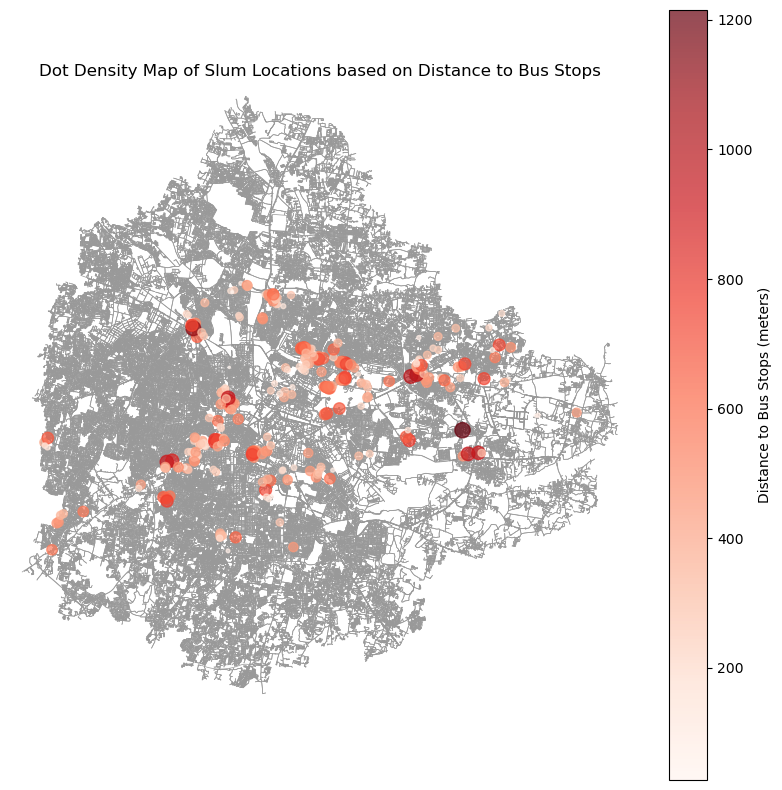

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

# Load the GeoDataFrame containing slum locations
# Assuming you have a GeoDataFrame named 'slum_locations' already loaded

# 5) Dot density map of slum locations based on distance to bus stops using OSMnx basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Fetch street network for Bangalore using OSMnx
G = ox.graph_from_place('Bangalore, India', network_type='all')

# Plot the street network as a basemap
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Plot slum locations with dot size based on distance to bus stops
sc = ax.scatter(
    slum_locations.geometry.x, slum_locations.geometry.y,
    c=slum_locations['BusStop_Distance'], cmap='Reds', s=slum_locations['BusStop_Distance']*0.1, alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Distance to Bus Stops (meters)')

ax.set_title('Dot Density Map of Slum Locations based on Distance to Bus Stops')
plt.show()

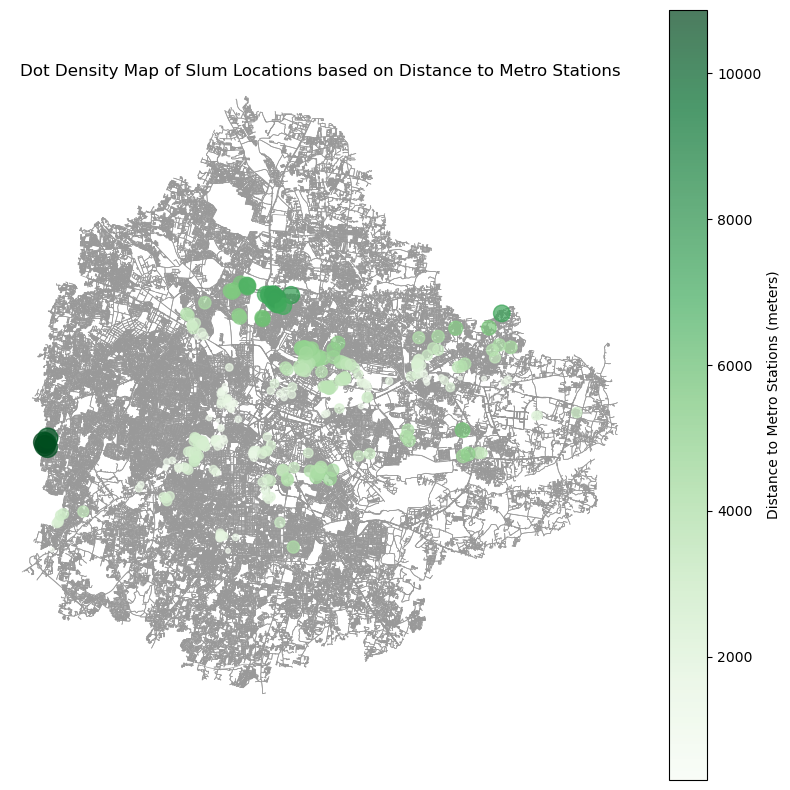

In [32]:
# Load the GeoDataFrame containing slum locations
# Assuming you have a GeoDataFrame named 'slum_locations' already loaded

# 6) Dot density map of slum locations based on distance to metro stations using OSMnx basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Fetch street network for Bangalore using OSMnx
G = ox.graph_from_place('Bangalore, India', network_type='all')

# Plot the street network as a basemap
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Plot slum locations with smaller dot size based on distance to metro stations
sc = ax.scatter(
    slum_locations.geometry.x, slum_locations.geometry.y,
    c=slum_locations['MetroStation_Distance'], cmap='Greens', s=slum_locations['MetroStation_Distance']*0.02, alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Distance to Metro Stations (meters)')

ax.set_title('Dot Density Map of Slum Locations based on Distance to Metro Stations')
plt.show()

/var/folders/bh/1t4fc4wn60n_xhv59kbyrm1r0000gn/T/ipykernel_32032/3595837617.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  metro_lines.centroid.plot(ax=ax, color='blue', markersize=50, label='Metro Stations')  # Plot metro stations


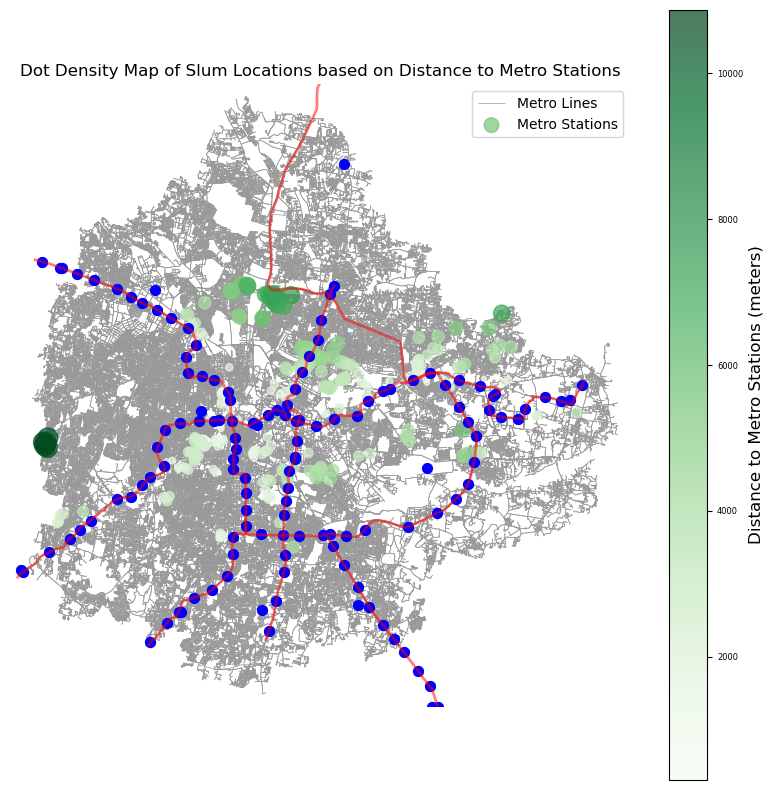

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import json

# Load metro lines and stations from geojson file
metro_lines = gpd.read_file('metro-lines-stations.geojson')

# Create a plot with OSMnx basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Fetch street network for Bangalore using OSMnx
G = ox.graph_from_place('Bangalore, India', network_type='all')

# Plot the street network as a basemap
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Plot slum locations with dot size based on distance to metro stations
sc = ax.scatter(
    slum_locations.geometry.x, slum_locations.geometry.y,
    c=slum_locations['MetroStation_Distance'], cmap='Greens', s=slum_locations['MetroStation_Distance']*0.02, alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Distance to Metro Stations (meters)')

# Overlay metro lines and stations
metro_lines.plot(ax=ax, linewidth=2, color='red', alpha=0.5)  # Plot metro lines
metro_lines.centroid.plot(ax=ax, color='blue', markersize=50, label='Metro Stations')  # Plot metro stations

# Set title and legend
ax.set_title('Dot Density Map of Slum Locations based on Distance to Metro Stations')
ax.legend(['Metro Lines', 'Metro Stations'])

plt.show()

/var/folders/bh/1t4fc4wn60n_xhv59kbyrm1r0000gn/T/ipykernel_32032/3618051933.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  metro_lines.centroid.plot(ax=ax, color='blue', markersize=50, label='Metro Stations')  # Plot metro stations


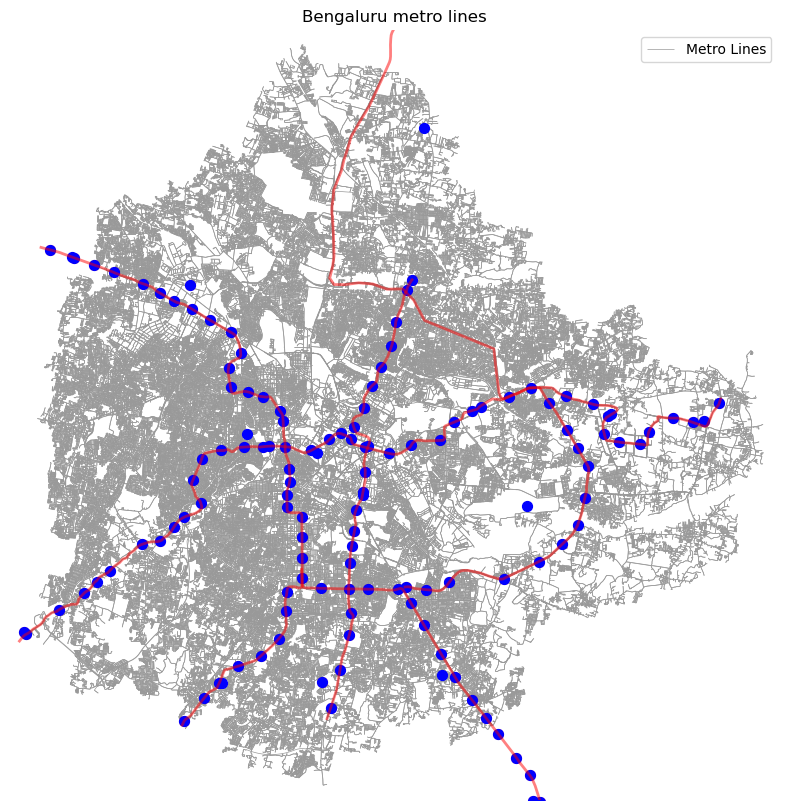

In [47]:
# Load metro lines and stations from geojson file
metro_lines = gpd.read_file('metro-lines-stations.geojson')

# Create a plot with OSMnx basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Fetch street network for Bangalore using OSMnx
G = ox.graph_from_place('Bangalore, India', network_type='all')

# Plot the street network as a basemap
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, show=False, close=False)


# Overlay metro lines and stations
metro_lines.plot(ax=ax, linewidth=2, color='red', alpha=0.5)  # Plot metro lines
metro_lines.centroid.plot(ax=ax, color='blue', markersize=50, label='Metro Stations')  # Plot metro stations

# Set title and legend
ax.set_title('Bengaluru metro lines')
ax.legend(['Metro Lines'])

plt.show()

In [26]:
import pandas as pd
import geopandas
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn

In [27]:
cluster_variables =  [
    'BusStop_Distance',          # Distance to nearest bus stop from a slum
    'MetroStation_Distance',          # Distance to nearest metro station from a slum
    'Pucca_Percentage',       # Percent of semi puccs households 
    'SemiPucca_Percentage', #Percent of pucca households 
    'Kaccha_Percentage',         # Percent of kaccha households
    'DensityHPH'    # household density
]

## Measuring spatial autocorrelations

In [19]:
from platform import python_version
print(python_version())

3.9.13


In [20]:
from pylab import rcParams
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter

## MEASURING VARIABLE CORRELATIONS

In [21]:
# Check for missing values
missing_values = slum_locations.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Slum_ID                  0
Slum_Name                0
SlumLoclty               0
No_HH                    0
Pucca_Hse                0
SemiPccaHs               0
Kaccha_Hse               0
Elec_Poles               2
Comn_Taps                1
Pub_Toilet               2
Sewer                    2
Manholes                 2
Source                   0
Bndry_Ref                0
Area                     0
DensityHPH               0
PbyA                     0
ORIG_FID                 0
geometry                 0
BusStop_Distance         7
MetroStation_Distance    7
Pucca_Percentage         2
SemiPucca_Percentage     2
Kaccha_Percentage        2
dtype: int64


In [22]:
# Check for zero variance (constant columns)
zero_variance_cols = slum_locations.columns[slum_locations.nunique() == 1]
print("Columns with Zero Variance:")
print(zero_variance_cols)

Columns with Zero Variance:
Index(['Source', 'Bndry_Ref'], dtype='object')


In [23]:
# Fill missing values with specified values
fill_values = {'Total_Length_metro': 3000, 'Total_Length_busstop': 402}
slum_locations.fillna(value=fill_values, inplace=True)

In [24]:
# Fill missing values with 0
slum_locations['Pucca_Percentage'].fillna(0, inplace=True)
slum_locations['SemiPucca_Percentage'].fillna(0, inplace=True)
slum_locations['Kaccha_Percentage'].fillna(0, inplace=True)

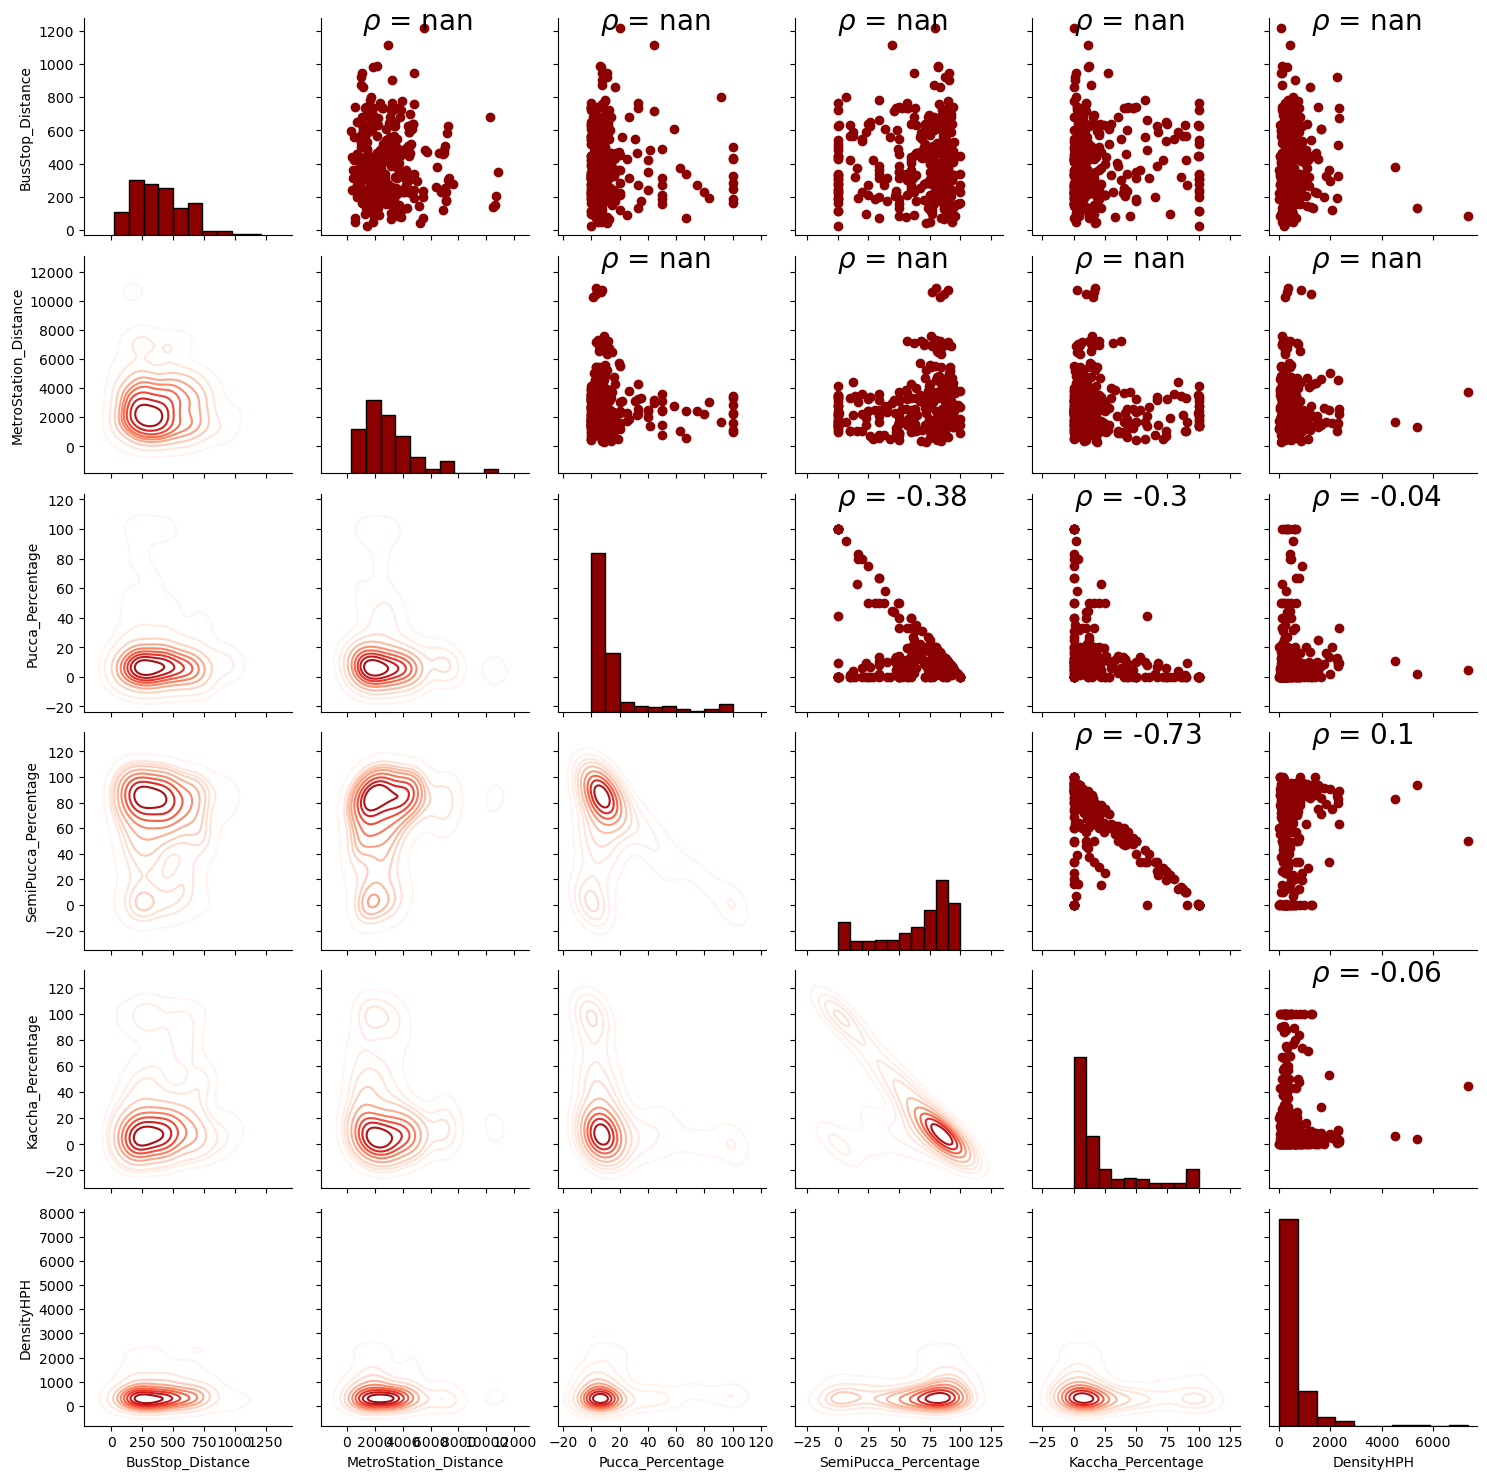

In [33]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)


grid = seaborn.PairGrid(slum_locations[cluster_variables])
# Map the plots to the locations

grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(seaborn.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 6
mpl.rcParams["ytick.labelsize"] = 6

plt.savefig('/Users/aneeshmugulur/Documents/Capstone/PairGrid.png')
plt.show()

## ELBOW METHOD

In [102]:
import pandas as pd
import geopandas
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn

In [103]:
from sklearn.preprocessing import robust_scale, scale

db_scaled = scale(slum_locations[cluster_variables])

In [104]:
Sum_of_squared_distances = []
K = range(1,7)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(db_scaled)
    Sum_of_squared_distances.append(km.inertia_)

In [105]:
Sum_of_squared_distances = []
K = range(1,7)
for k in K:
    km = KMeans(n_clusters=k)
    try:
        km = km.fit(db_scaled)
        Sum_of_squared_distances.append(km.inertia_)
    except AttributeError as e:
        print(f"An AttributeError occurred: {e}")

In [106]:
kmeans = KMeans(n_clusters=4)

In [107]:
numpy.random.seed(12)
# Running K-Means algorithm
k4cls = kmeans.fit(db_scaled)

In [108]:
k4cls.labels_

array([0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 3, 0, 2, 1,
       1, 0, 1, 1, 2, 1, 2, 1, 0, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 3, 1, 0, 0, 1, 0, 1, 0, 3, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 3, 2, 3, 1, 1, 1, 2, 0, 3, 0, 0, 2, 2, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2,
       1, 0, 3, 0, 3, 1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 0, 3, 1, 1, 1, 2,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1,
       0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 3, 0, 1, 2, 2, 3, 1,
       1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 3, 0, 3, 3, 1,
       0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 1,
       2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 3, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 3, 2, 1, 1, 2, 1, 0,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 3,

In [109]:
k4cls.cluster_centers_

array([[ 0.92281343, -0.347787  , -0.12182793,  0.37067149, -0.28113533,
         0.42211966],
       [-0.5304724 ,  0.41159267, -0.23359747,  0.52610148, -0.41172697,
        -0.1940796 ],
       [ 0.07992707, -0.43727532, -0.52589842, -1.61995833,  2.10021284,
        -0.12120332],
       [-0.35833309, -0.39569861,  3.10300378, -1.51688384, -0.58555894,
        -0.15144308]])

In [110]:
k4cls.inertia_

947.3347774676085

In [111]:
k4cls.n_iter_

16

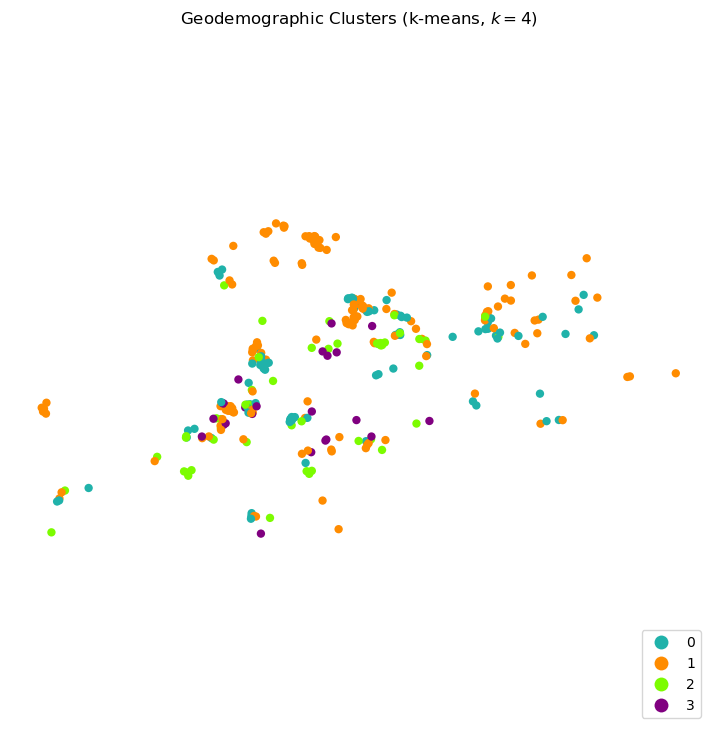

In [112]:
# Visualising clusters on the map

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmapTrial = ListedColormap(["lightseagreen", "darkorange", "lawngreen", "purple"])
slum_locations['k4cls'] = k4cls.labels_
f, ax = plt.subplots(1, figsize=(9, 9))
slum_locations.plot(column='k4cls', cmap=cmapTrial, categorical=True, legend=True, linewidth=0, ax=ax,legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
plt.axis('equal')
plt.title(r'Geodemographic Clusters (k-means, $k=4$)')
plt.show()

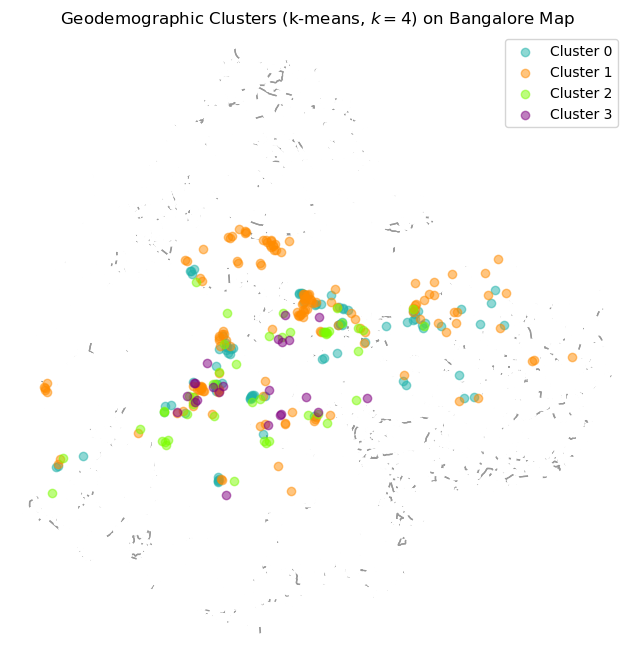

In [114]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the location (in this case, Bangalore)
location = "Bangalore, India"

# Retrieve the street network for the specified location
G = ox.graph_from_place(location, network_type='all')

# Plot the base map
fig, ax = ox.plot_graph(G, show=False, close=False)

#ox.plot_graph(G, ax=ax, node_color="black", edge_color="black", bgcolor="black", node_size=0, show=False)

# Plot the cluster points on top of the base map
for cluster_label, color in zip(slum_locations['k4cls'].unique(), cmapTrial.colors):
    cluster_data = slum_locations[slum_locations['k4cls'] == cluster_label]
    ax.scatter(cluster_data.geometry.x, cluster_data.geometry.y, color=color, label=f'Cluster {cluster_label}', alpha=0.5)

# Hide axis and set title
ax.set_axis_off()
plt.title(r'Geodemographic Clusters (k-means, $k=4$) on Bangalore Map')

# Show legend
plt.legend()

# Display the plot
plt.show()

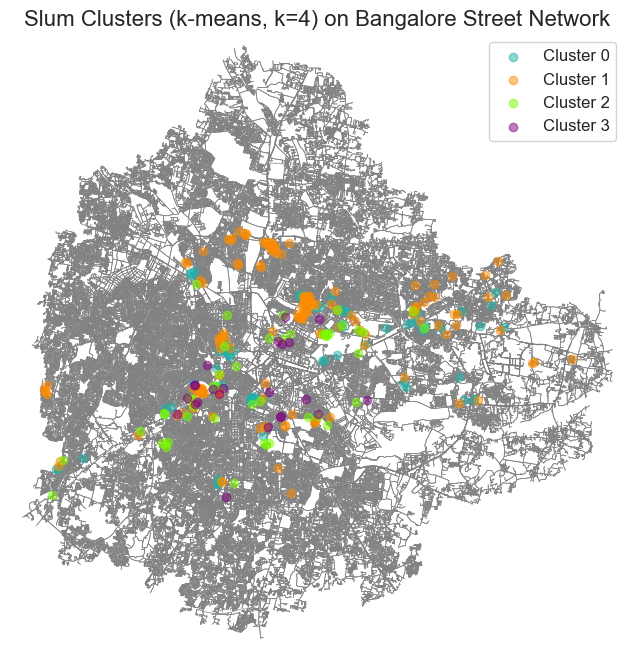

In [128]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the location (in this case, Bangalore)
location = "Bangalore, India"

# Retrieve the street network for the specified location
G = ox.graph_from_place(location, network_type='all')

# Plot the base map with a custom style
fig, ax = ox.plot_graph(G, bgcolor='white', edge_color='gray', edge_linewidth=0.5, node_color='none', show=False)

# Plot the cluster points on top of the base map
for cluster_label, color in zip(slum_locations['k4cls'].unique(), cmapTrial.colors):
    cluster_data = slum_locations[slum_locations['k4cls'] == cluster_label]
    ax.scatter(cluster_data.geometry.x, cluster_data.geometry.y, color=color, label=f'Cluster {cluster_label}', alpha=0.5)

# Hide axis and set title
ax.set_axis_off()
plt.title('Slum Clusters (k-means, k=4) on Bangalore Street Network', fontsize=16)

# Show legend
plt.legend(fontsize='12')

# Display the plot
plt.show()

In [142]:
# Grouping data table by cluster label and count observations
k4sizes = slum_locations.groupby('k4cls').size()
k4sizes

k4cls
0     91
1    150
2     48
3     23
dtype: int64

In [145]:
k5means= slum_locations.groupby('k4cls')[cluster_variables].mean()
k5means.T.round(2)

k4cls                       0        1        2        3
Total_Length_busstop   595.88   288.78   417.77   325.16
Total_Length_metro    2300.70  3717.25  2133.77  2211.33
Pucca_Percentage        10.95     8.67     2.71    76.71
SemiPucca_Percentage    75.76    80.45    15.63    18.75
Kaccha_Percentage       13.29     9.54    81.66     4.55
DensityHPH             834.03   406.99   457.49   436.53

In [116]:
slum_locations.shape

(312, 25)

In [117]:
# Index db on cluster ID
tidy_db = slum_locations.set_index('k4cls')
tidy_db = tidy_db[cluster_variables]
tidy_db = tidy_db.stack()
tidy_db = tidy_db.reset_index()
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute',
                        0: 'Values'})
tidy_db

k4cls             Attribute       Values
0         0  Total_Length_busstop  1215.288839
1         0    Total_Length_metro  5538.204149
2         0      Pucca_Percentage    20.000000
3         0  SemiPucca_Percentage    79.440000
4         0     Kaccha_Percentage     0.560000
...     ...                   ...          ...
1867      1    Total_Length_metro  1729.290644
1868      1      Pucca_Percentage     0.000000
1869      1  SemiPucca_Percentage     0.000000
1870      1     Kaccha_Percentage     0.000000
1871      1            DensityHPH     0.000000

[1872 rows x 3 columns]

In [120]:
import seaborn

# Set the font scale and style
seaborn.set(font_scale=2.2)
seaborn.set_style(style='white')

# Define colors for different clusters
color = {0: "lightseagreen", 1: "darkorange", 2: "lawngreen", 3: "purple"}

# Create a facet grid
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', palette=color, hue='k4cls', \
                  sharey=False, sharex=False, aspect=3, col_wrap=2)

# Map KDE plots onto the facet grid
_ = facets.map(seaborn.kdeplot, 'Values').add_legend(fontsize=30)

# Set legend title
facets.legend.set_title(' ')

# Set axis labels
facets.set_axis_labels("Value", "Density", fontsize=25)


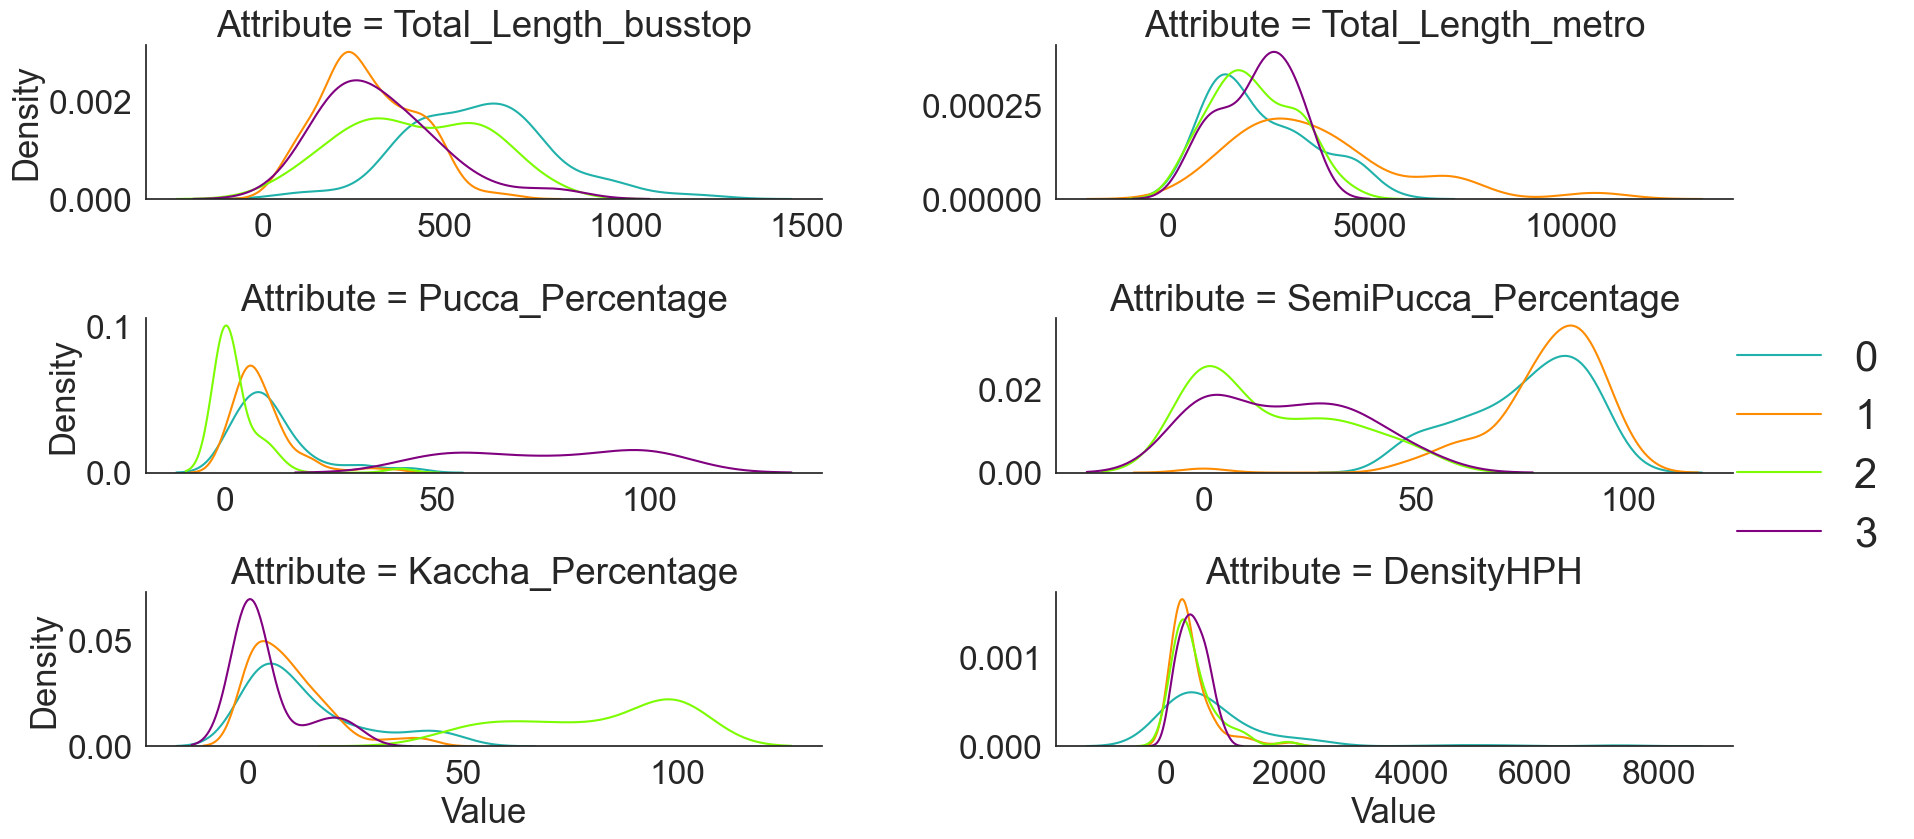

In [123]:
# Setup the facets
seaborn.set(font_scale=2.2)
seaborn. set_style(style='white')
color = {0:"lightseagreen", 1:"darkorange", 2:"lawngreen", 3:"purple"}
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', palette=color, hue='k4cls', \
                  sharey=False, sharex=False, aspect=3, col_wrap=2)
_ = facets.map(seaborn.kdeplot, 'Values').add_legend(fontsize=30)
facets.legend.set_title(' ')
facets.set_axis_labels("Value","Density",fontsize=25)
plt.show(facets)